In [42]:
import astropy
import sep
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = [10., 8.]

In [43]:
fname = 'hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'
hdu_list = fits.open(fname)
hdu_list.info()
print(hdu_list)

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


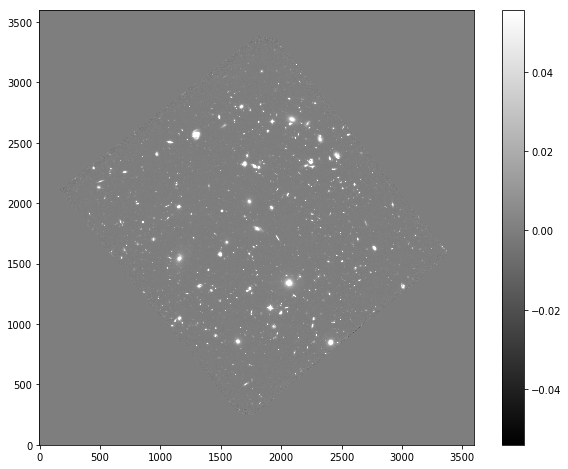

In [44]:
image_data = astropy.io.fits.getdata(fname)    #obtains the actual data from the fits file

#show image
m, s = np.mean(image_data), np.std(image_data) 
plt.imshow(image_data, interpolation = 'nearest', cmap = 'gray', vmin = m-s, vmax = m+s,  origin = 'lower')
plt.colorbar()

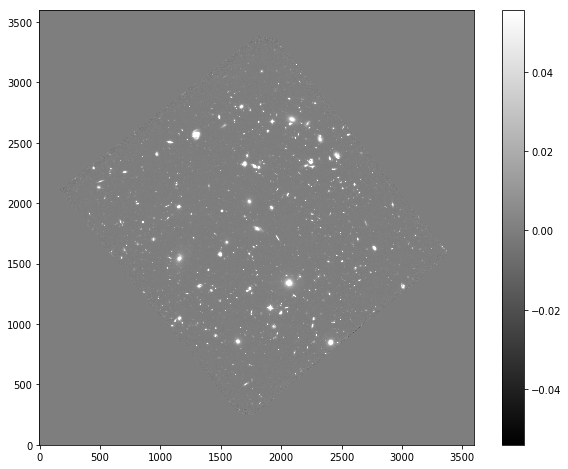

In [45]:
image_data = hdu_list[0].data
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation = 'nearest', cmap='gray', vmin = m-s, vmax = m+s, origin='lower')
plt.colorbar()

In [91]:
image_data = image_data.byteswap().newbyteorder()
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


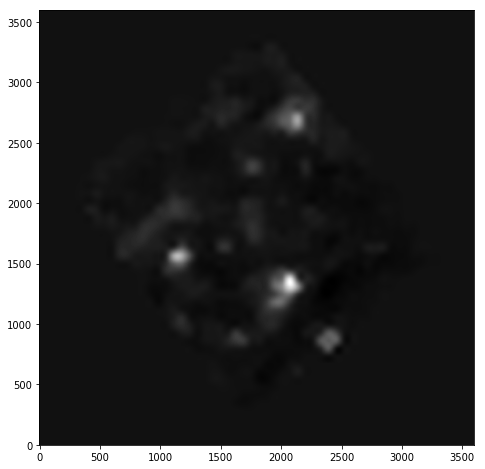

In [92]:
bkg_image = bkg.back() #evaluates background as a 2d array, like the original image
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')

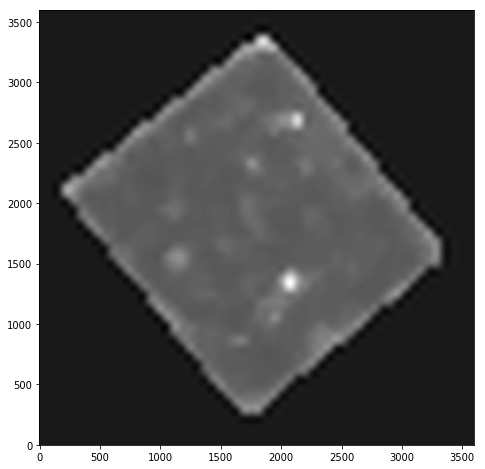

In [93]:
#background noise as a 2d array
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')

In [94]:
#subtract the background
image_data_sub = image_data-bkg

In [170]:
thresh = 50
objects = sep.extract(image_data_sub, thresh, err=bkg.globalrms*1.5)
#what should thresh be, depends on image?
print('Number of objects detected: ', len(objects))

Number of objects detected:  337


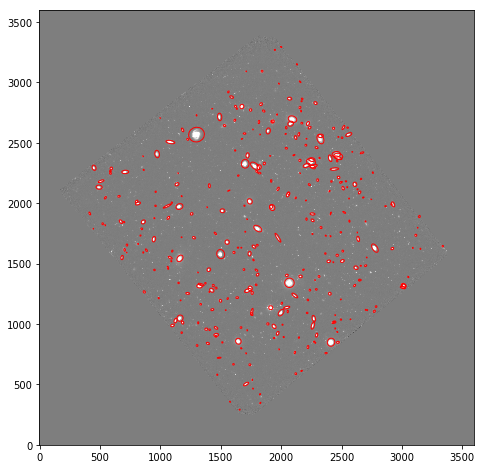

In [171]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(image_data_sub), np.std(image_data_sub)
im = ax.imshow(image_data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width=10*objects['a'][i], height=10*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

### Kehan Zou: Convert to AB magnitudes

In [173]:
flux, fluxerr, flag = sep.sum_circle(image_data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [175]:
for i in range(len(objects)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 1.149151 +/- 1.071988
object 1: flux = 1.124048 +/- 1.060215
object 2: flux = 0.836182 +/- 0.914434
object 3: flux = 1.253069 +/- 1.119409
object 4: flux = 0.966279 +/- 0.982999
object 5: flux = 3.191317 +/- 1.786428
object 6: flux = 1.042167 +/- 1.020870
object 7: flux = 1.423228 +/- 1.192994
object 8: flux = 2.253843 +/- 1.501283
object 9: flux = 1.203226 +/- 1.096920
object 10: flux = 8.215208 +/- 2.866220
object 11: flux = 1.310683 +/- 1.144854
object 12: flux = 1.472863 +/- 1.213619
object 13: flux = 1.027670 +/- 1.013745
object 14: flux = 1.926768 +/- 1.388084
object 15: flux = 1.485419 +/- 1.218781
object 16: flux = 1.044316 +/- 1.021922
object 17: flux = 1.413579 +/- 1.188944
object 18: flux = 2.076754 +/- 1.441097
object 19: flux = 2.317802 +/- 1.522436
object 20: flux = 3.382481 +/- 1.839154
object 21: flux = 1.118999 +/- 1.057832
object 22: flux = 1.315258 +/- 1.146850
object 23: flux = 3.314068 +/- 1.820460
object 24: flux = 1.107887 +/- 1.052566
object 25:

(0, 100)

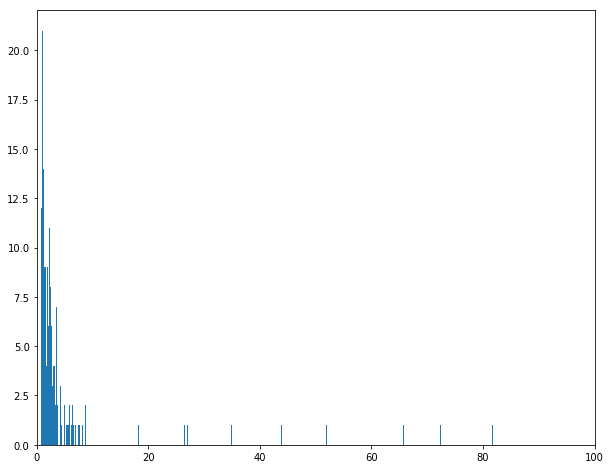

In [179]:
histogram = plt.hist(flux.flatten(), bins=10000)
plt.xlim(0,100)

In [195]:
import astropy.units as u, astropy.constants as c, numpy as np
u.Magnitude(-10.)  

u.Magnitude(10 * u.ct / u.s)  

u.Magnitude(-2.5, "mag(ct/s)")  

-2.5 * u.mag(u.ct / u.s)  

u.Dex((c.G * u.M_sun / u.R_sun**2).cgs)  

np.linspace(2., 5., 7) * u.Unit("dex(cm/s2)")  


AttributeError: module 'astropy.units' has no attribute 'flux'

In [185]:
logg = 5. * u.dex(u.cm / u.s**2)
logg.value

logg.physical 

<Quantity 100000. cm / s2>

In [186]:
tint = 1000.*u.s
cr_b = ([3000., 100., 15.] * u.ct) / tint
cr_v = ([4000., 90., 25.] * u.ct) / tint
b_i, v_i = u.Magnitude(cr_b), u.Magnitude(cr_v)
b_i, v_i 

(<Magnitude [-1.19280314,  2.5       ,  4.55977185] mag(ct / s)>,
 <Magnitude [-1.50514998,  2.61439373,  4.00514998] mag(ct / s)>)

In [187]:
b_i - v_i

<Magnitude [ 0.31234684, -0.11439373,  0.55462187] mag>

In [188]:
atm_ext_b, atm_ext_v = 0.12 * u.mag, 0.08 * u.mag
secz = 1./np.cos(45 * u.deg)
b_i0 = b_i - atm_ext_b * secz
v_i0 = v_i - atm_ext_b * secz
b_i0, v_i0 

(<Magnitude [-1.36250876,  2.33029437,  4.39006622] mag(ct / s)>,
 <Magnitude [-1.67485561,  2.4446881 ,  3.83544435] mag(ct / s)>)

In [192]:
b_ref, v_ref = 17.2 * u.ABmag, 17.0 * u.ABmag
b_ref, v_ref  

zp_b, zp_v = b_ref - b_i0[0], v_ref - v_i0[0]
zp_b, zp_v  

(<Magnitude 18.56250876 mag(AB s / ct)>,
 <Magnitude 18.67485561 mag(AB s / ct)>)